In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import time

In [2]:
""" Useful functions """
# boxcar function
def BC(x):
    return 1*(x+0.5>=0)-1*(x-0.5>=0)

# Heaviside function
def HS(x):
    return 0+x>=0;

# ramp function
def Ramp(x):
    return x*BC(x-1/2)+HS(x-1);

In [3]:
class FaultProblem:
    def __init__(self,rho,cs,mu,Kk,eta,fo,Vo,cca,ccb,Drs,sigma,Vpl,dgf):
        # bulk properties
        self.rho = rho
        self.cs = cs 
        self.mu = mu
        self.Kk = Kk
        self.eta = eta
        
        #fault properties
        self.fo = fo
        self.Vo = Vo
        self.cca = cca
        self.ccb = ccb
        self.Drs = Drs
        self.sigma = sigma
        self.Vpl = Vpl
        
        # number of parameters of interest
        self.dgf = dgf

In [4]:
"""
                                                      
            Stress Interaction Functions              
                                                      
 Vertical fault in a half-space centered at x2 = 0
 2D Antiplane problem (x2 x x3): 
 Out-of-plane displacements u1 are non-zero, u2 = u3 = 0
 u1 are assumed uniform along strike, only vary in x2 x x3 plane
 
                              x1             
                             /.          
                            /.          
                           /.           
  Free surface (x3 = 0).  /             
  ---------------------------------------------------->. x2
                         |
                         |
                         |. Vertical strike-slip 
                         |. rate-and-state fault
                         |
                         |
                         |
                          v  x3
"""
pi = np.pi

# density (kg/m^3)
rho = 2670

# shear wave speed (m/s)
cs = 3464

# shear modulus (MPa)
mu = rho*cs**2/1e6

# Elastostatic Green's functions for displacements and stress due to 
# uniform slip on a rectangular patch (Okada 1985,1992)
# For 2D antiplane we only care about Sigma_{12} 
# y-coordinates represent source, x-coordinates represent receiver

# Note that these solutions take into account a free-surface using
# the method of images

# Sigma_{12}
def s12h(x2,x3,y2,y3,W,mu):
    s12 = mu*( \
    -(x3-y3)/((x2-y2)**2+(x3-y3)**2)+(x3+y3)/((x2-y2)**2+(x3+y3)**2) \
    +(x3-y3-W)/((x2-y2)**2+(x3-y3-W)**2)-(x3+y3+W)/((x2-y2)**2+(x3+y3+W)**2) \
    )/2/pi
    return s12


# Displacement kernels due to fault slip
def u1h(x2,x3,y2,y3,W):
    u1 = (np.arctan((x3-y3)/(x2-y2))-np.arctan((x3+y3)/(x2-y2)) \
     -np.arctan((x3-y3-W)/(x2-y2))+np.arctan((x3+y3+W)/(x2-y2)) \
    )/2/pi
    return u1

In [28]:
"""                                                      
                     Set up Mesh                      
                                                    
 We consider an infinitely long vertical strike-slip fault 
 in the x1 direction, extending from the surface to a fixed  
 depth, with slip only varying in the x3 = z direction (down-dip)
"""

Lambdaz=40e3                                      # Depth extent of the frictional domain
M=400                                             # Number of cells  
dz=Lambdaz/M                                      # Cell size
y3=np.linspace(0,M-1,M).reshape( (M, ) )*dz       # Top of slip patch
y3p = y3+0.5*dz                                   # Center of patch
y3pp = np.linspace(0,M,M+1).reshape( (M+1, ) )*dz # for plotting 
W=np.ones((M,1))*dz                               # Down-dip width of slip patch

# Surface points (virtual GPS receivers crossing the fault in x2)
nsta = 100
eps = 1e-6  # just to shift coordinates off of x2 = 0
x2GPSR =  (200e3*np.tan(eps+np.linspace(0,nsta/2,nsta)*pi/(2*nsta)))
x2GPSL = (-200e3*np.tan(eps+np.linspace(0,nsta/2,nsta)*pi/(2*nsta)))
x2GPS = np.concatenate((np.flipud(x2GPSL),x2GPSR),axis=0)

In [16]:
"""
                       Kernels                        
"""
Kk=np.zeros((M,M))                        # stress kernels 
ku1=np.zeros((x2GPS.size,M))              # surface displacement kernels for GPS
for k in range(M):
    # Evaluate the stress at the center of the slip patches
    # Coordinate from source is top of patch
    # s1h(x2,x3,y2,y3,W,G)
    Kk[:,k]=s12h(0,y3p,0,y3[k],W[k],mu);
    
    # Displacement kernels
    # u1h(x2,x3,y2,y3,W)
    ku1[:,k]=u1h(x2GPS,0,0,y3[k],W[k]);



In [17]:
"""                                                    
                    Fault Properties                  
"""

# reference friction coefficient
fo=0.6*np.ones((y3.size,))

# Dieterich-Ruina R+S frictional parameters (velocity-weakening friction)
cca=1e-2+Ramp((y3-15e3)/3e3)*(0.025-0.01)
ccb=0.015*np.ones((y3.size,))

# effective normal stress (MPa)
sigma=50.0*np.ones((y3.size,))

# characteristic weakening distance (m)
Drs=8e-3*np.ones((y3.size,))

# plate rate (m/s)
Vpl=1e-9*np.ones((y3.size,))

# reference slip rate (m/s)
Vo=1e-6*np.ones((y3.size,))

# Radiation damping coefficient
eta = mu/(2*cs)

# Estimates of some key parameters
VWp = np.argwhere(ccb>cca) # VW region
VWp = VWp[:,0]
# Critical nucleation size ( h* = pi/2 G b D_rs / (b-a)^2 / sigma )
hstar=np.min(pi/2*mu*Drs[VWp]*ccb[VWp]/(ccb[VWp]-cca[VWp])**2/sigma[VWp])

# Quasi-static cohesive zone ( coh0 = 9/32 G D_rs /(b*sigma) ) 
# Note that for this QD simulation the cohesive zone will not change,
# which would not be the case for a fully dynamic simulation
Lvw = (y3[VWp[-1]]-y3[VWp[0]]) # size of VW region
coh = np.min(9/32*pi*mu*Drs[VWp]/ccb[VWp]/sigma[VWp])

# Estimate of recurrence time ( T ~ 5(b-a)*sigma / mu * 0.5 Lvw/Vpl ) 
Ti = 5*np.mean((ccb[VWp]-cca[VWp])*sigma[VWp])*0.5*Lvw/(mu*np.mean(Vpl[VWp]))

# Print information about discretization
print("Grid size = %.2f (m)\n" % (dz))
print("VW zone = %.2f (km)\n" % (Lvw/1e3))
print("Critical nucleation size = %.2f (m)\n" % (hstar))
print("QS Cohesive zone = %.2f (m)\n" % (coh))
print("Est. Recurrence time = %.2f (yr)\n" % (Ti/3.15e7))

Grid size = 100.00 (m)

VW zone = 15.90 (km)

Critical nucleation size = 4831.23 (m)

QS Cohesive zone = 301.95 (m)

Est. Recurrence time = 9.57 (yr)



In [18]:
def DieterichRuinaRegAging(t,y,fp):
    """
    This function describes the evolution of the ordinary
    differential equation y' = f(t,y), where the state 
    vector y is 

            /        s          \
        y = |       tau         |
            | log(theta Vo / D_rs) |
            \    log(V / Vo)    /

     based on the regularized form of Dieterich-Ruina rate-and-state friction 
     and using the aging law

     Velocity is determined by the balance of shear resistance and shear stress
     Resistance : tau = a sigma asinh( V/2Vo exp( (fo + b psi ) / a))
     Stress     : tau = tauo + f(z,t) - eta*V  
     Where we use radiation damping to approximate the inertial terms
     as the quasi-dynamic approximation with f(z,t) = K(delta - Vpl*t)

     This is done by taking the time-derivative of both equations and equating
     the two.

       a sigma  alpha/ sqrt(1 + alpha^2) ( 1/V dV/dt + b/a dPhi/dt) 
     
                       = K( V - Vpl) - eta dV/dt

     where 
          alpha = V / 2Vo exp( ( fo + b phi) / a)



     Note this form assumes no time variation in sigma, the frictional
     parameters, or the loading plate rate. Loading is done purely through
     back slip at plate rate Vpl.

     Instead of directly integrating numerically the aging law

        d theta / dt = 1 - V theta / D_rs

     as is, we operate the following change of variable

        phi = ln (theta Vo / D_rs)

     where we obtain the evolution law for the new variable
 
        d phi / dt = ( Vo exp(-phi) - V ) / D_rs

     Given the regularized form of Dieterich-Ruina R+S we can express,
        1 dV      K (V - Vpl) - b sigma dphi / dt Q
        - --  =  ----------------------------------
        V dt           a sigma Q  + eta V
  
     where

                                1
        Q = -----------------------------------------------
            /                                             \(1/2)
            |  1 + [2 Vo / V exp(-(fo + b phi) / a )]^2   |
            \                                             /
 
     Note that d/dt log(V/Vo) = 1/V dV/dt, and is much more efficient to
     integrate than dV/dt alone
    """
    # State variable
    th=y[2::fp.dgf]

    # Slip rate
    V = fp.Vo*np.exp(y[3::fp.dgf])

    # Initialize Time Derivative
    yp=np.zeros(y.shape)

    # Slip
    yp[0::fp.dgf]=V

    # State Variable
    dth = (fp.Vo*np.exp(-th)-V)/fp.Drs
    yp[2::fp.dgf]=dth

    # Slip Velocity
    func = np.matmul(fp.Kk,(V-fp.Vpl))
    f1=2*fp.Vo/V*np.exp(-(fp.fo+fp.ccb*th)/fp.cca)
    f2=1/np.sqrt(1+f1**2)

    yp[3::fp.dgf] = (func - fp.ccb*fp.sigma*dth*f2)/ \
                    (fp.cca*fp.sigma*f2 + fp.eta*V)


    # Evolution of shear stress 
    yp[1::fp.dgf]=func - fp.eta*V*yp[3::fp.dgf];

    return yp

In [19]:
"""                     Numerical Solution                

     Use Runge-Kutta 4th / 5th order accurate integration to 
     solve the ODE time integration problem with adaptive time-steps
         yp = f(t,y)
         Y = [slip; stress; state variable; log10(slip rate / ref slip rate)]
"""

# Degrees of Freedom                                                   
dgf=4 

fp = FaultProblem(rho,cs,mu,Kk,eta,fo,Vo,cca,ccb,Drs,sigma,Vpl,dgf)

# Initial conditions (start at steady-state with zero slip)
Y0=np.zeros(M*dgf,);   
Y0[0::dgf]=np.zeros(M,);   
Y0[1::dgf]=np.max(cca)*sigma*np.arcsinh(Vpl/Vo/2*np.exp((fo+ccb*np.log(Vo/Vpl))/np.max(cca))) + eta*Vpl
Y0[2::dgf]=cca/ccb*np.log(2*Vo/Vpl*np.sinh((Y0[1::dgf]-eta*Vpl)/cca/sigma))-fo/ccb
Y0[3::dgf]=np.log(Vpl/Vo)

def yp(t,Y):
    yp = DieterichRuinaRegAging(t,Y,fp)
    return yp
 

# ODE45 Settings
t0 = 0              # initial time
tf = 500*3.15e7     # final time
dtmax = 3.15e7

start = time.time()
sol = sp.integrate.solve_ivp(yp, [t0, tf], Y0, method='RK45', max_step=dtmax, rtol=1e-8, atol=1e-6, vectorized=False, first_step=1e-5)
end = time.time()
print(f'Finished, calculaton time: {end-start:.3f} s')


Finished, calculaton time: 2.619 s


In [20]:
"""                        Prepare Figures                       """
Y = np.transpose(np.asarray(sol.y))
t = np.asarray(sol.t)
Vt = np.multiply(Vo,np.exp(Y[:,3::dgf]))        # Slip rate (m/s)
taut = Y[:,2::dgf]                              # Shear stress (MPa)
Vmax = np.zeros(t.size,);                       # Maximum slip rate (m/s)
Vcenter = Vt[:,int(np.floor(M/2))];             # Slip rate at center of VW region
for ti in range(t.size):
    Vmax[ti] = np.max(Vt[ti,:]);

    
# GPS time series (displacement in x1 direction)
shistory = Y[:,0::dgf]
UGPS = np.matmul(ku1,np.transpose(shistory))

In [31]:
Vt.shape

(9884, 400)

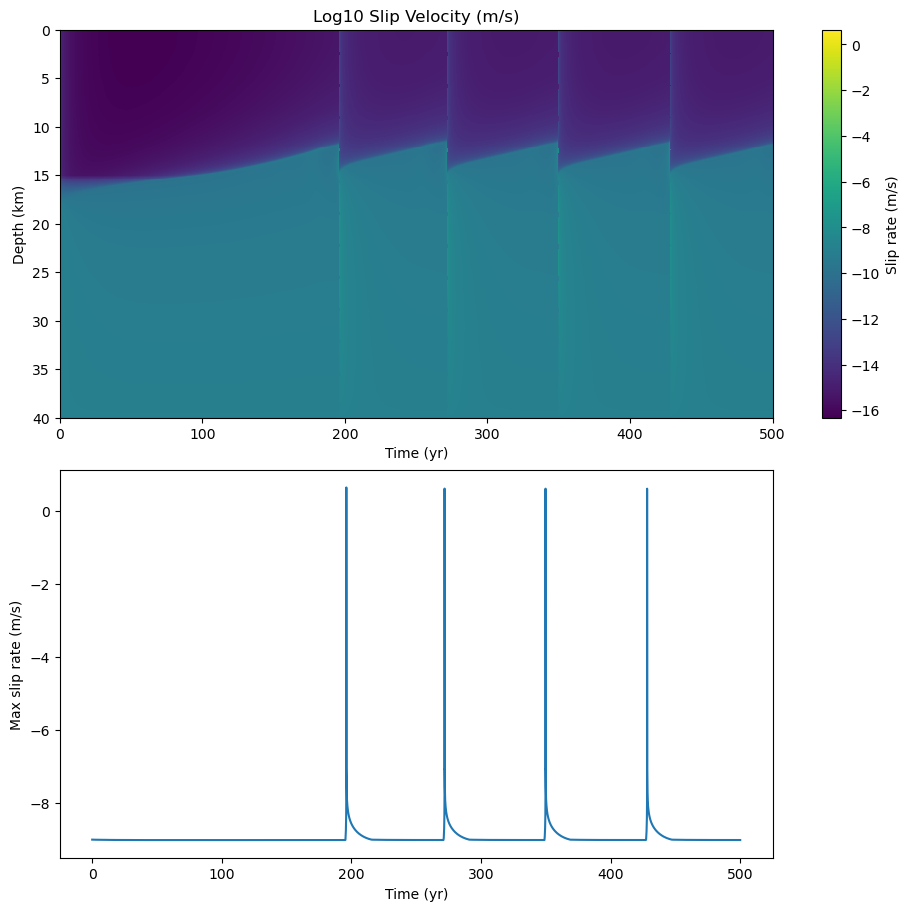

In [32]:
# Plot space-time colormaps of fault slip rate
fig,ax = plt.subplots(2,1,figsize=[9,9],constrained_layout=True)   

# First plot colormap of slip rate over space and time
axs = ax[0]
c = axs.pcolor( t/3.15e7,y3pp/1e3,np.transpose(np.log10(Vt[0:-1,:])), cmap='viridis', shading='flat')
axs.set_title('Log10 Slip Velocity (m/s)')
axs.set_xlabel('Time (yr)')
axs.set_ylabel('Depth (km)')
axs.invert_yaxis()
cb1 = fig.colorbar(c, ax=axs)
cb1.set_label('Slip rate (m/s)')

# Plot maximum slip rate along the fault over time
axs = ax[1]
d = axs.plot(t/3.15e7,np.log10(Vmax))
axs.set_xlabel('Time (yr)')
axs.set_ylabel('Max slip rate (m/s)')
              
#plt.tight_layout()
plt.show()

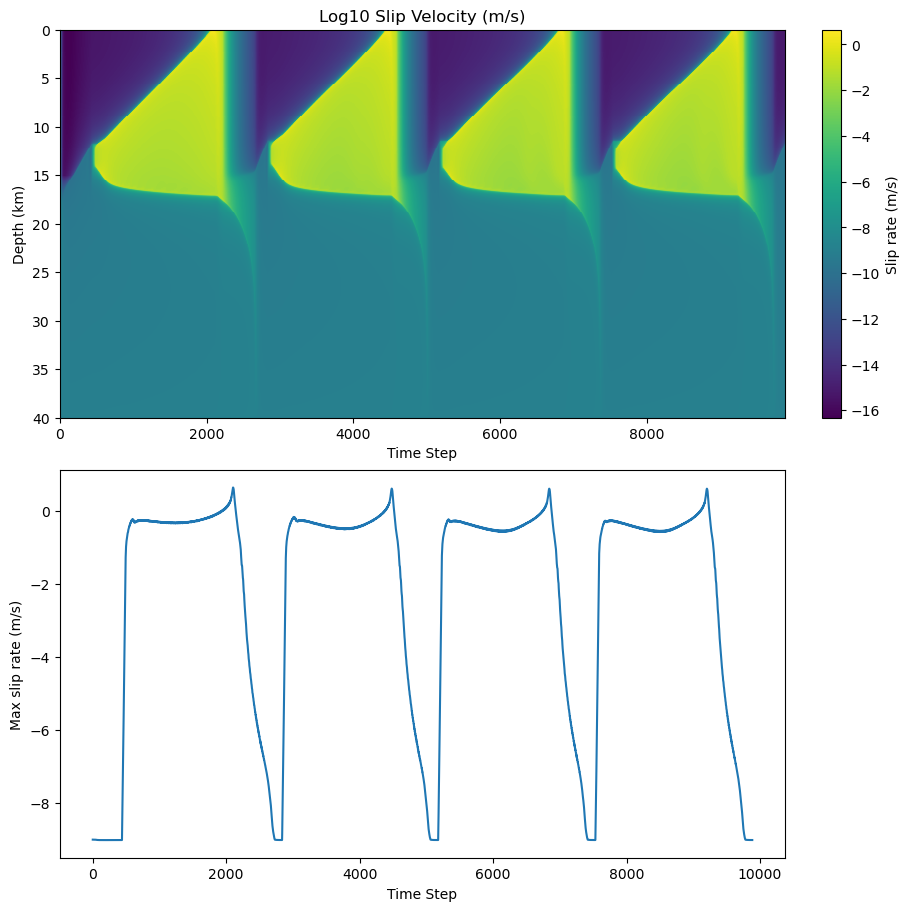

In [12]:
# Let's make the same plot but in the time-step domain rather than time
fig,ax = plt.subplots(2,1,figsize=[9,9],constrained_layout=True)   

ndts = np.linspace(0,t.size-1,t.size).reshape( (t.size, ) )

# First plot colormap of slip rate over space and time
axs = ax[0]
c = axs.pcolor( ndts,y3p/1e3,np.transpose(np.log10(Vt[0:-1,:])), cmap='viridis', shading='flat')
axs.set_title('Log10 Slip Velocity (m/s)')
axs.set_xlabel('Time Step')
axs.set_ylabel('Depth (km)')
axs.invert_yaxis()
cb1 = fig.colorbar(c, ax=axs)
cb1.set_label('Slip rate (m/s)')

# Plot maximum slip rate along the fault over time
axs = ax[1]
d = axs.plot(ndts,np.log10(Vmax))
axs.set_xlabel('Time Step')
axs.set_ylabel('Max slip rate (m/s)')
              
plt.show()

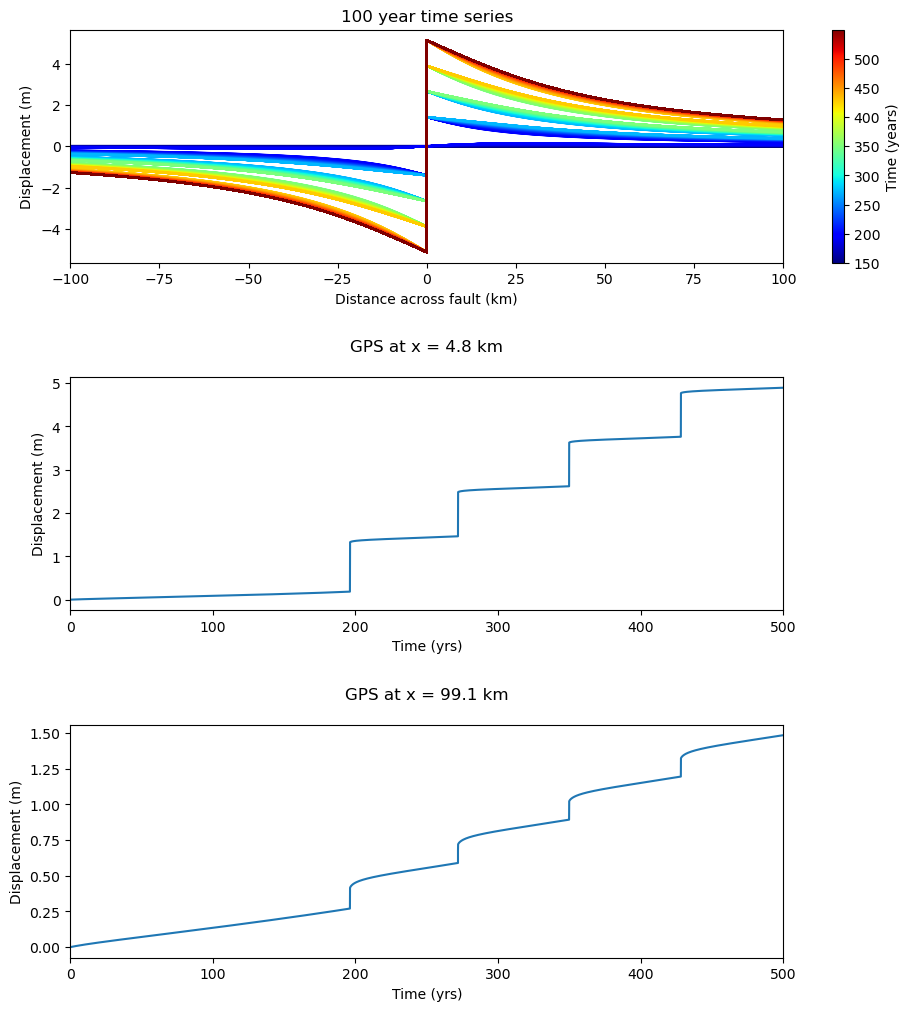

In [22]:
""" Let's plot some synthetic GPS time series """
dtsamp = 2.628e6           # 1 month sampling
t0rec = 150*3.15e7         # Initial time for record
MaxRecordT = 400*3.15e7    # 400 years time series
RecordT = t0rec + np.arange(0,MaxRecordT,dtsamp)
tindx = np.zeros(RecordT.size,)

# Create an array sampling time steps of fault displacement for the GPS records
for tstep in range(RecordT.size):
    tindx[tstep] = np.searchsorted(t, RecordT[tstep], side="left")-1


fig,ax = plt.subplots(3,1,figsize=[9,10],constrained_layout=True) 

cmap = plt.get_cmap("jet", len(RecordT))
norm = mpl.colors.Normalize(vmin=min(RecordT/3.15e7), vmax=max(RecordT/3.15e7)) 
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot the overall surface patterns colored with time across the fault
axs = ax[0]
for tstep in range(RecordT.size):
    d = axs.plot(x2GPS/1e3,UGPS[:,int(tindx[tstep])] - UGPS[:,int(tindx[0])],color=cmap(tstep))

cb2=fig.colorbar(sm,ax=axs)
cb2.set_label('Time (years)')
axs.set_xlim(-100, 100) 
axs.set_xlabel('Distance across fault (km)')
axs.set_ylabel('Displacement (m)')
axs.set_title('100 year time series')

# Plot time series for specific points
GPS1 = np.argmin( np.absolute(x2GPS-5e3))   # GPS station around 5 km from fault
GPS2 = np.argmin( np.absolute(x2GPS-100e3)) # GPS station around 100 km from fault

axs = ax[1]
d = axs.plot(t/3.15e7,UGPS[GPS1,:])
axs.set_xlim(min(t/3.15e7), max(t/3.15e7)) 
axs.set_xlabel('Time (yrs)')
axs.set_ylabel('Displacement (m)')
axs.set_title('GPS at x = %.1f km\n' % (x2GPS[GPS1]/1e3))

axs = ax[2]
d = axs.plot(t/3.15e7,UGPS[GPS2,:])
axs.set_xlim(min(t/3.15e7), max(t/3.15e7)) 
axs.set_xlabel('Time (yrs)')
axs.set_ylabel('Displacement (m)')
axs.set_title('GPS at x = %.1f km\n' % (x2GPS[GPS2]/1e3))

fig.get_layout_engine().set(hspace=0.1)
